In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, auc, roc_auc_score, roc_curve,
                            confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve)

# Load the dataset

In [48]:
# Load the dataset
df = pd.read_csv("twitter_dataset_small_w_bart_preds.csv")

In [49]:
# Display the first few rows of the dataset
print(df.head())

   is_positive          id                      datetime            user  \
0            0  2200003313  Tue Jun 16 18:18:13 PDT 2009   DEWGetMeTho77   
1            0  1467998601  Mon Apr 06 23:11:18 PDT 2009         Young_J   
2            0  2300049112  Tue Jun 23 13:40:12 PDT 2009   dougnawoschik   
3            0  1993474319  Mon Jun 01 10:26:09 PDT 2009        thireven   
4            0  2256551006  Sat Jun 20 12:56:51 PDT 2009  taracollins086   

                                             message  bart_is_positive  
0  @Nkluvr4eva My poor little dumpling  In Holmde...          0.005163  
1  I'm off too bed. I gotta wake up hella early t...          0.339430  
2  I havent been able to listen to it yet  My spe...          0.065703  
3  now remembers why solving a relatively big equ...          0.004046  
4                           Ate too much, feel sick           0.000581  


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_positive       20000 non-null  int64  
 1   id                20000 non-null  int64  
 2   datetime          20000 non-null  object 
 3   user              20000 non-null  object 
 4   message           20000 non-null  object 
 5   bart_is_positive  20000 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 937.6+ KB


# Exploratory Data Analysis

In [51]:
# Count the number of occurrences of each value in the 'is_positive' column
df['is_positive'].value_counts().to_frame()

,is_positive
1,10058
0,9942


In [52]:
# Calculate the percentage of each value in the 'is_positive' column 
(df['is_positive'].value_counts(normalize=True) * 100).round(2).to_frame()

,is_positive
1,50.29
0,49.71


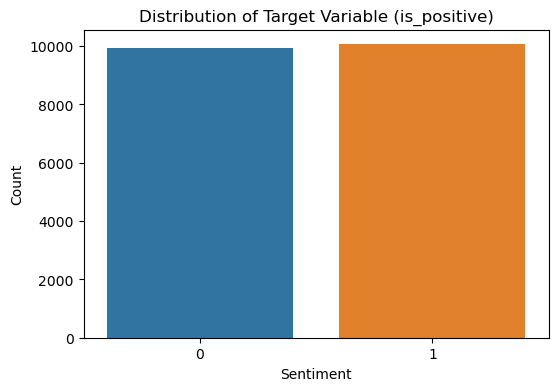

In [53]:
# Bar chart for distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='is_positive', data=df)
plt.title('Distribution of Target Variable (is_positive)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

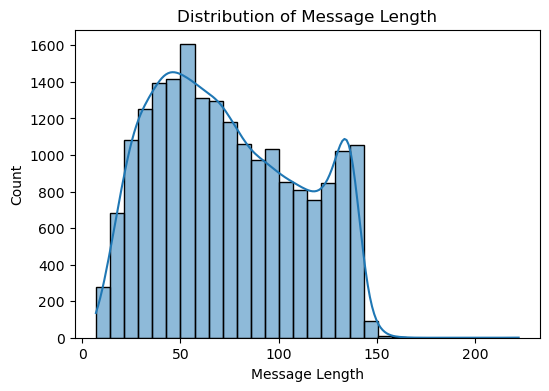

In [54]:
# Histogram for distribution of message length
df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(df['message_length'], bins=30, kde=True)
plt.title('Distribution of Message Length')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

In [55]:
# Check the maximum message length
max_length = df['message'].apply(len).max()
print(max_length)

222


# Preprocessing and cleaning of data

In [56]:
# Define text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove Twitter handles (user mentions)
    text = re.sub(r'@[^\s]+', '', text)
    
     # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization using NLTK
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back into a string
    text = ' '.join(tokens)
    
    return text

# Apply preprocessing to the 'message' column
df['processed_message'] = df['message'].apply(preprocess_text)

# Display the first few rows of the preprocessed dataset
print(df[['message', 'processed_message']].head())

                                             message  \
0  @Nkluvr4eva My poor little dumpling  In Holmde...   
1  I'm off too bed. I gotta wake up hella early t...   
2  I havent been able to listen to it yet  My spe...   
3  now remembers why solving a relatively big equ...   
4                           Ate too much, feel sick    

                                   processed_message  
0  poor little dumpling holmdel vids really tryin...  
1    im bed got ta wake hella early tomorrow morning  
2             havent able listen yet speakers busted  
3  remembers solving relatively big equation two ...  
4                                 ate much feel sick  


In [57]:
df.head()

,is_positive,id,datetime,user,message,bart_is_positive,message_length,processed_message
0,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...,0.005163,111,poor little dumpling holmdel vids really tryin...
1,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,Young_J,I'm off too bed. I gotta wake up hella early t...,0.339430,63,im bed got ta wake hella early tomorrow morning
2,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,dougnawoschik,I havent been able to listen to it yet My spe...,0.065703,62,havent able listen yet speakers busted
3,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,thireven,now remembers why solving a relatively big equ...,0.004046,98,remembers solving relatively big equation two ...
4,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,taracollins086,"Ate too much, feel sick",0.000581,24,ate much feel sick


# Train logistic regression model

In [58]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df['processed_message'], df['is_positive'], test_size=0.2, random_state=42
)

In [59]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [60]:
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

# Model evaluation and validation

In [61]:
# Predictions on the validation set
y_val_pred = model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72      1987
           1       0.72      0.76      0.74      2013

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



<Figure size 800x600 with 0 Axes>

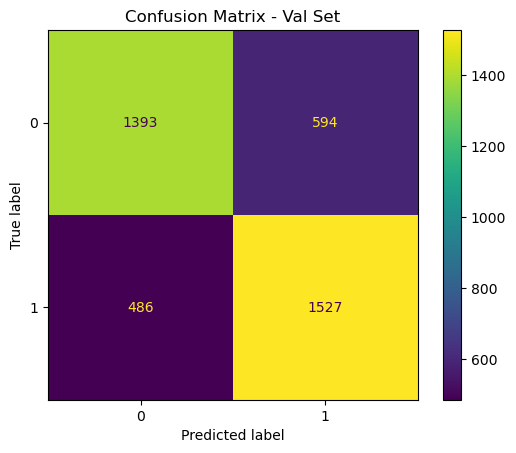

In [62]:
# Get Confusion Matrix and display it as a plot
cm_val = confusion_matrix(y_val, y_val_pred, labels=model.classes_)

cm_plot_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val, display_labels=model.classes_
)
plt.figure(figsize=(8, 6))
cm_plot_val.plot()
plt.title('Confusion Matrix - Val Set')
plt.show()

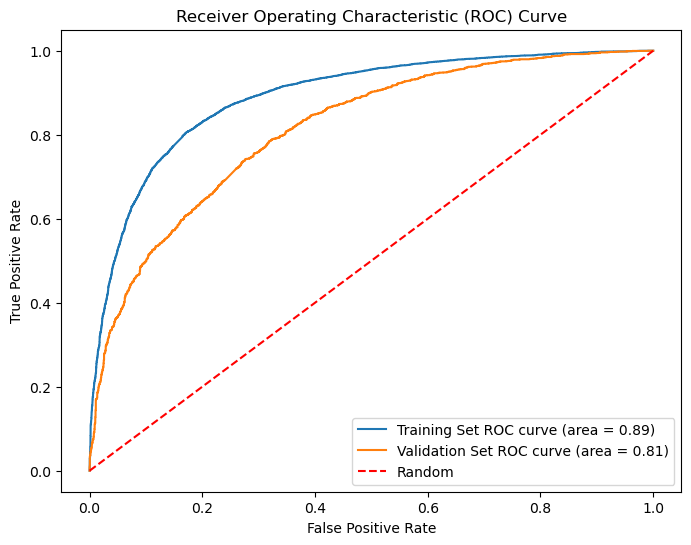

In [63]:
# Get the predicted probabilities for the positive class
y_train_prob = model.predict_proba(X_train_tfidf)[:, 1]
y_val_prob = model.predict_proba(X_val_tfidf)[:, 1]

# Compute the ROC curve and AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute the ROC curve and AUC for the validation set
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot the ROC curves for both training and validation sets on the same plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training Set ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, label=f'Validation Set ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Comparison of the trained model with BART

In [64]:
# BART predictions
y_pred_bart = df['bart_is_positive'].round().astype(int)

In [65]:
# Evaluate BART predictions
bart_accuracy = accuracy_score(df['is_positive'], y_pred_bart)
bart_report = classification_report(df['is_positive'], y_pred_bart)

print(f'BART Accuracy: {bart_accuracy}')
print('BART Classification Report:\n', bart_report)

BART Accuracy: 0.7101
BART Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.91      0.76      9942
           1       0.85      0.52      0.64     10058

    accuracy                           0.71     20000
   macro avg       0.75      0.71      0.70     20000
weighted avg       0.75      0.71      0.70     20000



<Figure size 800x600 with 0 Axes>

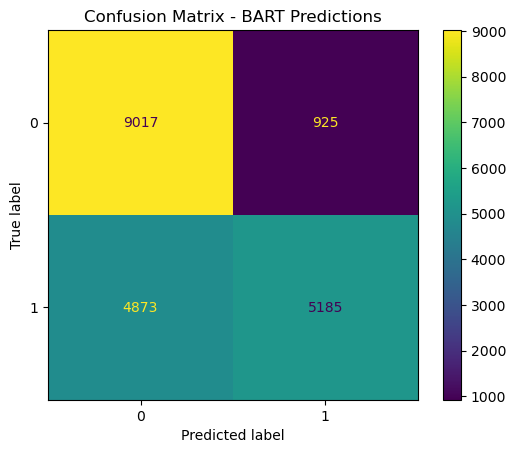

In [66]:
# Get Confusion Matrix for BART predictions
cm_bart = confusion_matrix(df['is_positive'], y_pred_bart)

# Display Confusion Matrix for BART predictions
cm_plot_bart = ConfusionMatrixDisplay(
    confusion_matrix=cm_bart, display_labels=[0, 1]
)
plt.figure(figsize=(8, 6))
cm_plot_bart.plot()
plt.title('Confusion Matrix - BART Predictions')
plt.show()

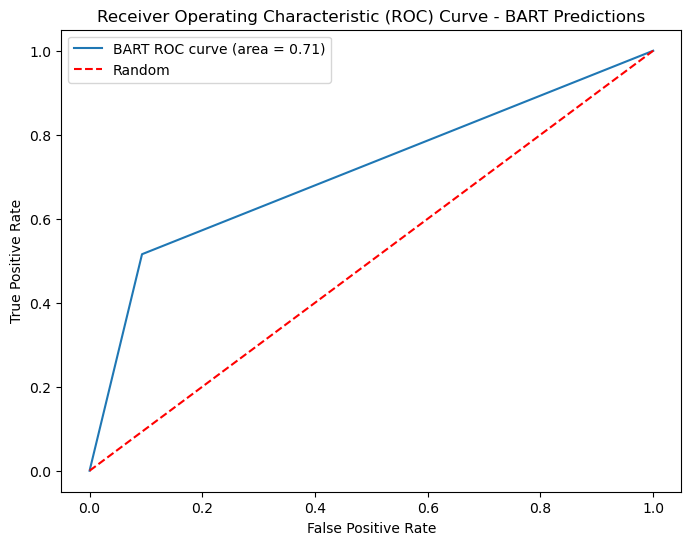

In [67]:
# Compute the ROC curve and AUC for BART predictions
fpr_bart, tpr_bart, _ = roc_curve(df['is_positive'], y_pred_bart)
roc_auc_bart = auc(fpr_bart, tpr_bart)

# Plot the ROC curve for BART predictions
plt.figure(figsize=(8, 6))
plt.plot(fpr_bart, tpr_bart, label=f'BART ROC curve (area = {roc_auc_bart:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - BART Predictions')
plt.legend()
plt.show()